<a href="https://www.kaggle.com/code/ruchui271/ex02-cnn?scriptVersionId=160116266" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.naive_bayes
import sklearn.ensemble as ske
import sklearn.neighbors
import sklearn.pipeline
import sklearn.linear_model
import joblib
from sklearn import preprocessing
from sklearn import tree, linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif

import sys
import sqlite3
import importlib
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Activation, Flatten, Input, Multiply, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from keras.models import Sequential, Model #for keras sequential model
from keras import optimizers

In [3]:
df_wild = pd.read_pickle('/kaggle/input/wild-pickle/wild.pickle')

In [4]:
MAX_LENGTH = int(1e6)
prev_size = len(df_wild)
df_wild = df_wild[df_wild['generic_fileSize'] <= MAX_LENGTH]
print("considering samples with size less than {} bytes, {} ----> {}".format(MAX_LENGTH, prev_size, len(df_wild)))

considering samples with size less than 1000000 bytes, 50724 ----> 37354


In [5]:
df_wild.head()

,sample_sha1,benign,malicious,packed,unpacked_sample_sha1,unpacked_sample_id,packer_name,imp_setupremovefilelogentrya,imp_vardeccmp,imp_setdlgitemint,...,opcode_xor sub mov,opcode_xor sub mov add,opcode_xor test,opcode_xor test je,opcode_xor xor,opcode_xor xor mov,opcode_xor xor pop,opcode_xor xor pop mov,opcode_xor xor xor,opcode_xor xor xor pop
1,a2aac23e17be570c647fd22080e05b0e58449565,True,False,True,-1,-1,none,False,False,False,...,0.000022,0.0,0.000088,0.000084,0.000070,0.000066,0.000028,0.0,0.000053,0.0
2,c3aa534bbd20f3a3dd8e7a457f625291af9d0fe4,False,True,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000309,0.000000,0.000000,0.0,0.000331,0.0
10,15cb9eab6b0f0ccd718a9235f07046dff100789f,False,True,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
12,8792cf08950abada1572b47948e86c9fce26c01a,True,False,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
13,353a955ae9919f7b639d74394e3c1149f0189362,True,False,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000204,0.000190,0.000066,0.000091,0.000000,0.0,0.000000,0.0


In [6]:
print(df_wild.shape)

(37354, 56555)


In [7]:
#Chọn ngẫu nhiên 1,200 mẫu
df = df_wild.sample(n=1200, random_state=102)

In [8]:
df = df.drop(['sample_sha1','benign','unpacked_sample_sha1','unpacked_sample_id'], axis=1)
df = df.drop(['benign_vt','malicious_vt'], axis=1)

In [9]:
string_columns = df.select_dtypes(include=['object']).columns
df = df.drop(string_columns, axis=1)

In [10]:
df.head()

,malicious,packed,imp_setupremovefilelogentrya,imp_vardeccmp,imp_setdlgitemint,imp_?append@?$basic_string@du?$char_traits@d@std@@v?$allocator@d@2@@std@@qaeaav12@abv12@ii@z,imp_zwwritefile,imp_glstencilop,imp_comparelinkinforeferents,imp__setmbcp,...,opcode_xor sub mov,opcode_xor sub mov add,opcode_xor test,opcode_xor test je,opcode_xor xor,opcode_xor xor mov,opcode_xor xor pop,opcode_xor xor pop mov,opcode_xor xor xor,opcode_xor xor xor pop
32148,False,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000187,0.000198,0.0,0.0,0.0,0.0,0.0,0.0
210953,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50313,False,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
200288,True,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
49579,True,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print(df.shape)

(1200, 56526)


In [12]:
df_train = df.sample(n=1000, random_state=102)
df_test = df.drop(df_train.index)

In [13]:
data = df_train.sample(n=500, random_state=102)

In [14]:
#Kiểm tra số lượng mẫu
UB = data[(data['malicious'] == False) & (data['packed'] == False)].shape[0]
PM = data[(data['malicious'] == True) & (data['packed'] == True)].shape[0]
PB = data[(data['malicious'] == False) & (data['packed'] == True)].shape[0]
print('Unpacked Benign: %i samples' % UB)
print('Packed Malware: %i samples' % PM)
print('Packed Benign: %i samples' % PB)
print('Total TRAIN set: %i samples'% (UB+PM+PB))

Unpacked Benign: 39 samples
Packed Malware: 363 samples
Packed Benign: 98 samples
Total TRAIN set: 500 samples


In [15]:
#Chia tỉ lệ 50 - 50
data_PM = data[(data['malicious'] == True) & (data['packed'] == True)].sample(n=(PM-(UB+PB)), random_state=102)
data = data.drop(data_PM.index)

In [16]:
#Số lượng tập train
UB = data[(data['malicious'] == False) & (data['packed'] == False)].shape[0]
PM = data[(data['malicious'] == True) & (data['packed'] == True)].shape[0]
PB = data[(data['malicious'] == False) & (data['packed'] == True)].shape[0]
print('Unpacked Benign: %i samples' % UB)
print('Packed Malware: %i samples' % PM)
print('Packed Benign: %i samples' % PB)
print('Total TRAIN set: %i samples'% (UB+PM+PB))

Unpacked Benign: 39 samples
Packed Malware: 137 samples
Packed Benign: 98 samples
Total TRAIN set: 274 samples


In [17]:
#Xử lý tập train
y = data['malicious'].values
data = data.drop(['malicious','packed'], axis=1)

In [18]:
UB = df_test[(df_test['malicious'] == False) & (df_test['packed'] == False)].shape[0]
PM = df_test[(df_test['malicious'] == True) & (df_test['packed'] == True)].shape[0]
PB = df_test[(df_test['malicious'] == False) & (df_test['packed'] == True)].shape[0]

df_test_PM = df_test[(df_test['malicious'] == True) & (df_test['packed'] == True)].sample(n=(PM-(UB+PB)), random_state=102)
df_test = df_test.drop(df_test_PM.index)

UB = df_test[(df_test['malicious'] == False) & (df_test['packed'] == False)].shape[0]
PM = df_test[(df_test['malicious'] == True) & (df_test['packed'] == True)].shape[0]
PB = df_test[(df_test['malicious'] == False) & (df_test['packed'] == True)].shape[0]

print('Unpacked Benign: %i samples' % UB)
print('Packed Malware: %i samples' % PM)
print('Packed Benign: %i samples' % PB)
print('Total TEST set: %i samples'% (UB+PM+PB))

Unpacked Benign: 10 samples
Packed Malware: 46 samples
Packed Benign: 36 samples
Total TEST set: 92 samples


In [19]:
fsel = SelectKBest(score_func=mutual_info_classif, k=100)
fsel.fit(data, y)
features = fsel.get_support(indices = True)
features = [column for column in data.columns[features]]

In [20]:
# model = SelectFromModel(fsel, prefit=True)
# X = model.transform(data)

X_train = fsel.transform(data)
X_test = fsel.transform(df_test.drop(['malicious','packed'], axis=1))

# Lấy tên đặc trưng tương ứng cho X_train và X_test
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

y_train = y
y_test = df_test['malicious'].values

In [21]:
X_train_array = X_train.values
X_test_array = X_test.values

# Reshape
X_train_new = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_new = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

In [22]:
n_timesteps, n_features = X_train_new.shape[1], X_train_new.shape[2]

In [23]:
def Cnn():
    model = Sequential()
    model.add(Input(shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=256, kernel_size=2, activation='relu', name="Conv1D_1"))
    model.add(Activation('sigmoid'))
    model.add(Conv1D(filters=256, kernel_size=2, name="Conv1D_2"))  
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(Conv1D(filters=128, kernel_size=3, name="Conv1D_3"))
    model.add(Conv1D(filters=128, kernel_size=3, name="Conv1D_4"))
    model.add(AveragePooling1D(2))
    model.add(Conv1D(filters=64, kernel_size=4, name="Conv1D_5"))
    model.add(Conv1D(filters=64, kernel_size=4, name="Conv1D_6"))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu', name="Dense_1"))
    model.add(Dropout(0.35))
    model.add(Dense(1, activation='sigmoid', name="Dense_2"))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [24]:
CNN_model = Cnn()
#print the model summary
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 99, 256)           768       
                                                                 
 activation (Activation)     (None, 99, 256)           0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 98, 256)           131328    
                                                                 
 MaxPooling1D (MaxPooling1D  (None, 49, 256)           0         
 )                                                               
                                                                 
 Conv1D_3 (Conv1D)           (None, 47, 128)           98432     
                                                                 
 Conv1D_4 (Conv1D)           (None, 45, 128)           49280     
                                                        

Epoch 1/100
5/5 - 3s - loss: 1.6396 - accuracy: 0.4781 - val_loss: 0.8119 - val_accuracy: 0.5000 - 3s/epoch - 587ms/step
Epoch 2/100
5/5 - 0s - loss: 0.9824 - accuracy: 0.4635 - val_loss: 0.9729 - val_accuracy: 0.5000 - 468ms/epoch - 94ms/step
Epoch 3/100
5/5 - 0s - loss: 0.9471 - accuracy: 0.5073 - val_loss: 0.6758 - val_accuracy: 0.5000 - 438ms/epoch - 88ms/step
Epoch 4/100
5/5 - 0s - loss: 0.8080 - accuracy: 0.5255 - val_loss: 0.6435 - val_accuracy: 0.6957 - 466ms/epoch - 93ms/step
Epoch 5/100
5/5 - 0s - loss: 0.6408 - accuracy: 0.6606 - val_loss: 0.7068 - val_accuracy: 0.5000 - 443ms/epoch - 89ms/step
Epoch 6/100
5/5 - 0s - loss: 0.6967 - accuracy: 0.5620 - val_loss: 0.6486 - val_accuracy: 0.5000 - 452ms/epoch - 90ms/step
Epoch 7/100
5/5 - 0s - loss: 0.6515 - accuracy: 0.5839 - val_loss: 0.7337 - val_accuracy: 0.5870 - 440ms/epoch - 88ms/step
Epoch 8/100
5/5 - 0s - loss: 0.6464 - accuracy: 0.6496 - val_loss: 0.7408 - val_accuracy: 0.6087 - 435ms/epoch - 87ms/step
Epoch 9/100
5/5 - 

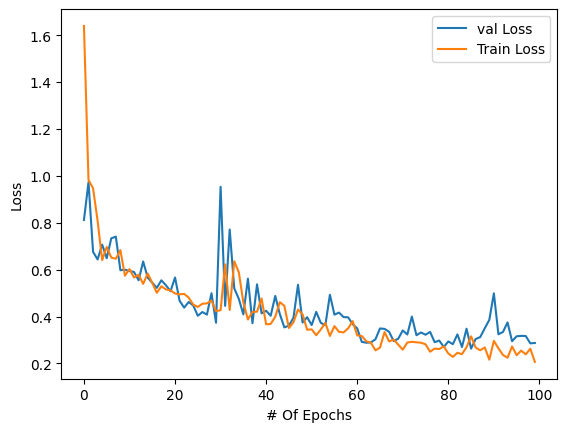

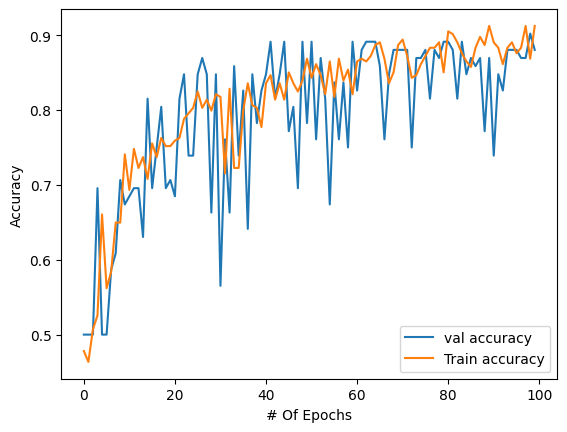

In [25]:
history_cnn = CNN_model.fit(X_train_new, y_train, epochs=100, batch_size=64, validation_data=(X_test_new,y_test), verbose=2)

#for plotting losses curve
loss_training = history_cnn.history['loss']
loss_test = history_cnn.history['val_loss']

#for plotting accyracies curve
accuracy_training = history_cnn.history['accuracy']
accuracy_test = history_cnn.history['val_accuracy']

loss_training = history_cnn.history['loss']
loss_test = history_cnn.history['val_loss']

accuracy_training = history_cnn.history['accuracy']
accuracy_test = history_cnn.history['val_accuracy']

#for Plotting
plt.plot(loss_test)
plt.plot(loss_training)

#set the titles of losses plot
plt.xlabel("# Of Epochs")
plt.ylabel("Loss")
plt.legend(['val Loss', 'Train Loss'])
plt.show()

#set the titles of accuracies plot
plt.plot(accuracy_test)
plt.plot(accuracy_training)
plt.xlabel("# Of Epochs")
plt.ylabel("Accuracy")
plt.legend(['val accuracy', 'Train accuracy'])
plt.show()

In [26]:
#calculate and print the validation accuracy
scores = CNN_model.evaluate(X_train_new, y_train)
print('Final validation accuraccy: ')
print("Loss:", scores[0], " Accuracy:", scores[1])

9/9 [==============================] - 0s 21ms/step - loss: 0.1925 - accuracy: 0.9124
Final validation accuraccy: 
Loss: 0.1925482600927353  Accuracy: 0.9124087691307068


In [27]:
#calculate and print the testing accuracy
scores_test = CNN_model.evaluate(X_test_new, y_test)
print('Final testing accuraccy: ')
print("Loss:", scores_test[0], " Accuracy:", scores_test[1])

3/3 [==============================] - 0s 21ms/step - loss: 0.2872 - accuracy: 0.8804
Final testing accuraccy: 
Loss: 0.2872271239757538  Accuracy: 0.8804348111152649


In [28]:
#make the model prediction
pred = CNN_model.predict(X_test_new)

3/3 [==============================] - 0s 19ms/step


In [29]:
Y_pred = (pred > 0.5) * 1.0
Y_pred = Y_pred.reshape(y_test.shape)

In [30]:
report = metrics.classification_report(y_test, Y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.80      0.87        46
        True       0.83      0.96      0.89        46

    accuracy                           0.88        92
   macro avg       0.89      0.88      0.88        92
weighted avg       0.89      0.88      0.88        92



In [31]:
class_labels = list(X_test_new)

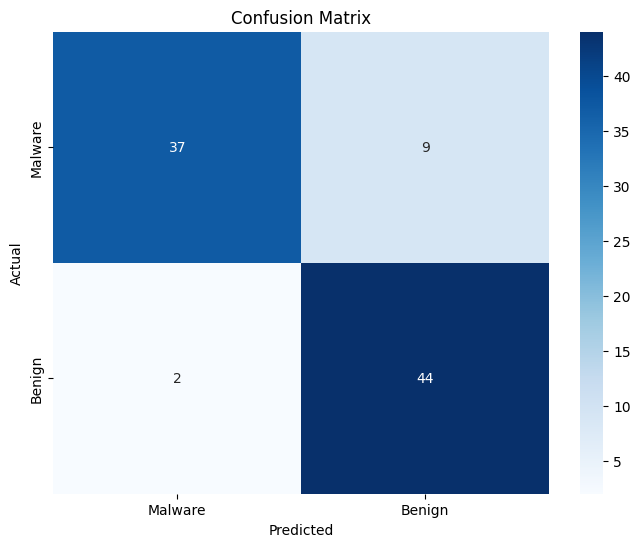

In [32]:
import seaborn as sns
cm = confusion_matrix(y_test, Y_pred)

# Hiển thị confusion matrix bằng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malware', 'Benign'],
            yticklabels=['Malware', 'Benign'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()